In [ ]:
# Added RelU and dropout in b/w

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/quora-question-pairs/

/content/drive/My Drive/quora-question-pairs


In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator, Example
import torchtext.vocab as vocab
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv("input/train.csv", 
                  #  nrows=20000
                   )

In [ ]:
data.dropna(subset = ["question1", "question2"], inplace=True)

In [ ]:
data.shape

(404287, 6)

In [ ]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train, valid = model_selection.train_test_split(
        data, test_size=0.1, random_state=42, stratify=data.is_duplicate.values
    )

In [ ]:
train.to_csv('input/train_split.csv',index = False)
valid.to_csv('input/validation_split.csv',index = False)

In [ ]:
# Specifying how the data should be pre-processed.
question_1 = Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True, lower=True)

question_2 = Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True, lower=True)


target = Field(sequential=False, use_vocab=False)

# Specifying which columns to use from Dataset, and which Field should be used to process each column.
fields = {'question1' : ('q1',question_1), 'question2' : ('q2',question_2), 'is_duplicate' : ('t', target)}

In [ ]:
train_data, valid_data = TabularDataset.splits(
                                path='input/',
                                train='train_split.csv',
                                test='validation_split.csv',
                                format='csv',
                                fields=fields)

In [ ]:
glove_embeddings = vocab.Vectors(name = '/content/drive/My Drive/glove/glove.6B.100d.txt')

In [ ]:
question_1.build_vocab(train_data, max_size=20000, vectors=glove_embeddings)
question_2.build_vocab(train_data, max_size=20000, vectors=glove_embeddings)


In [ ]:
train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), batch_size=32, sort_key = lambda x: len(x.q1)+len(x.q2), sort_within_batch=True, device=device
)


In [ ]:
class Net(nn.Module):
    # defining the structure of the network
    def __init__(self, input_size_q1, input_size_q2, embed_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_q1 = nn.Embedding(input_size_q1, embed_size)
        self.embedding_q2 = nn.Embedding(input_size_q2, embed_size)
        self.rnn1 = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.rnn2 = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1)
        )

    # defining steps in forward pass
    def forward(self, x1, x2):
      # Set initial hidden and cell states
      # h0_q1 = torch.zeros(self.num_layers, x1.size(0),  self.hidden_size).to(device)
      # c0_q1 = torch.zeros(self.num_layers, x1.size(0), self.hidden_size).to(device)

      # h0_q2 = torch.zeros(self.num_layers, x2.size(1), self.hidden_size).to(device)
      # c0_q2 = torch.zeros(self.num_layers, x2.size(1), self.hidden_size).to(device)

      embedded_q1 = self.embedding_q1(x1)
      embedded_q2 = self.embedding_q2(x2)


      # output of the LSTM - shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features (h_t) from the last layer of the LSTM, for each t.
      # We are only interested in the hidden state at the last time step.
      outputs_q1, _ = self.rnn1(embedded_q1)#, (h0_q1, c0_q1))
      outputs_q2, _ = self.rnn2(embedded_q2)#, (h0_q2, c0_q2))

      output_1 = outputs_q1[:, -1, :]
      output_2 = outputs_q2[:, -1, :]
      
      concatenated_output = torch.cat((output_1, output_2), dim=1)
      prediction = self.fc(concatenated_output)

      return prediction

In [ ]:
# Hyperparameters
input_size_q1 = len(question_1.vocab)
input_size_q2 = len(question_2.vocab)
hidden_size = 512
num_layers = 2
embedding_size = 100
learning_rate = 0.003
num_epochs = 10

In [ ]:
model = Net(input_size_q1, input_size_q2, embedding_size, hidden_size, num_layers).to(device)

In [ ]:
#Load the pretrained embeddings onto our model
embedding_weights_q1 = question_1.vocab.vectors
model.embedding_q1.weight.data.copy_(embedding_weights_q1)
model.embedding_q1.weight.requires_grad=False

embedding_weights_q2 = question_2.vocab.vectors
model.embedding_q2.weight.data.copy_(embedding_weights_q2)
model.embedding_q2.weight.requires_grad=False

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=learning_rate)

In [ ]:
writer = SummaryWriter(f'runs/LSTM-Dropout-0.3-10')

In [ ]:
def accuracy(logits,label):
  sigmoid = nn.Sigmoid()(logits)
  predictions = torch.round(sigmoid)
  predictions = predictions.view(logits.shape[0])
  return (predictions == label).sum().float()/float(label.size(0))

In [ ]:
def train_fn(data_loader, model, optimizer, device):
    model.train()
    epoch_train_accuracy = 0
    epoch_train_loss = 0
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):

      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      targets = batch.t.to(device=device)
      
      predictions = model(q1, q2)
      loss = criterion(predictions.squeeze(1), targets.type_as(predictions))

      optimizer.zero_grad()

      # backward
      loss.backward()
      optimizer.step()

      batch_accuracy = accuracy(predictions, targets)
      epoch_train_accuracy += batch_accuracy.item()
      epoch_train_loss += loss.item()

    
    return epoch_train_loss/len(data_loader), epoch_train_accuracy/len(data_loader)

In [ ]:
def eval_fn(data_loader, model, device):
  model.eval()
  epoch_valid_accuracy = 0
  epoch_valid_loss = 0
  with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      targets = batch.t.to(device=device)
      predictions = model(q1, q2)
      loss = criterion(predictions.squeeze(1), targets.type_as(predictions))
      batch_accuracy = accuracy(predictions, targets)
      epoch_valid_accuracy += batch_accuracy.item()
      epoch_valid_loss += loss.item()
  
  return epoch_valid_loss/len(data_loader), epoch_valid_accuracy/len(data_loader)

In [ ]:
train_loss_values = []
valid_loss_values = []
train_accuracies = []
valid_accuracies = []
best_accuracy = 0
step = 0
for epoch in range(num_epochs):
  train_loss, train_accuracy =  train_fn(train_iterator, model, optimizer, device)
  writer.add_scalar('Train Epoch loss', train_loss, global_step=step)
  writer.add_scalar('Train Epoch Accuracy', train_accuracy, global_step=step)
  train_loss_values.append(train_loss)
  train_accuracies.append(train_accuracy)
  valid_loss, valid_accuracy = eval_fn(valid_iterator, model, device)
  writer.add_scalar('Valid Epoch loss', valid_loss, global_step=step)
  writer.add_scalar('Valid Epoch Accuracy', valid_accuracy, global_step=step)
  valid_loss_values.append(valid_loss)  
  valid_accuracies.append(valid_accuracy)
  print(f"Epoch {epoch} Train loss - {train_loss} Train accuracy - {train_accuracy} Valid loss - {valid_loss} Valid accuracy - {valid_accuracy}")
  step+=1
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), "models/model.bin")
    best_accuracy = valid_accuracy


Epoch 0 Train loss - 0.6596418967801907 Train accuracy - 0.6305492651901818 Valid loss - 0.6584769608806583 Valid accuracy - 0.6309468567937235



Epoch 1 Train loss - 0.6586537295491324 Train accuracy - 0.6308082085036947 Valid loss - 0.6584521284963512 Valid accuracy - 0.6309468567937235



Epoch 2 Train loss - 0.636472525454618 Train accuracy - 0.6326455456863952 Valid loss - 0.6036589229007876 Valid accuracy - 0.6618260102747362



Epoch 3 Train loss - 0.5889359891038543 Train accuracy - 0.6880123901939593 Valid loss - 0.5640067510642819 Valid accuracy - 0.7160932175532172



Epoch 4 Train loss - 0.560609559578245 Train accuracy - 0.7156814606363127 Valid loss - 0.5382486376498791 Valid accuracy - 0.7268230435025843



Epoch 5 Train loss - 0.539970765262318 Train accuracy - 0.7275653709711956 Valid loss - 0.5257206309669286 Valid accuracy - 0.7365886685025843



Epoch 6 Train loss - 0.53629212063086 Train accuracy - 0.7324718582358631 Valid loss - 0.5276362330806029 Valid accuracy - 0.730210108376002



Epoch 7 Train loss - 0.5262077991605701 Train accuracy - 0.7384141187650654 Valid loss - 0.5459604828288378 Valid accuracy - 0.739283486540559



Epoch 8 Train loss - 0.5316072116029257 Train accuracy - 0.7339943716471726 Valid loss - 0.5303905042760735 Valid accuracy - 0.7450439691354956



Epoch 9 Train loss - 0.5220854714812263 Train accuracy - 0.741821299797731 Valid loss - 0.5391471135323938 Valid accuracy - 0.7421266431861286


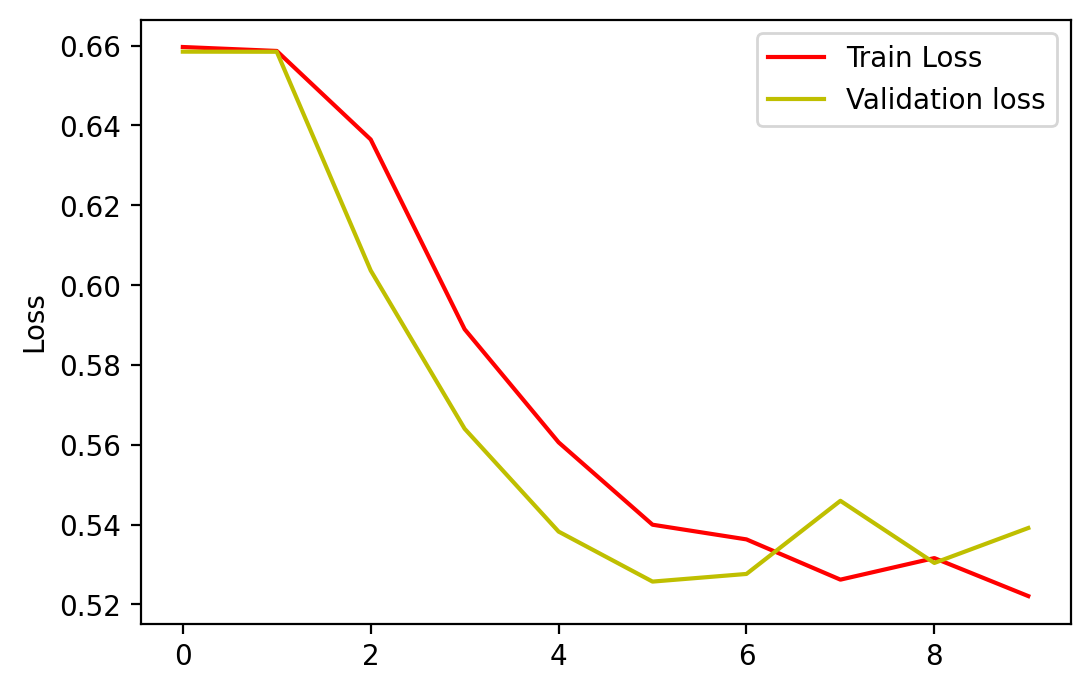

In [ ]:
fig = plt.figure(dpi=200)
plt.ylabel("Loss")
plt.plot(np.array(train_loss_values), 'r')
plt.plot(np.array(valid_loss_values), 'y')
plt.legend(["Train Loss", "Validation loss"], loc ="upper right") 

In [ ]:
test_fields = {'question1' : ('q1',question_1), 'question2' : ('q2',question_2)}

In [ ]:
test = pd.read_csv("input/test.csv")

In [ ]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
test_data = TabularDataset(
                            path='input/test.csv',
                            format='CSV',
                            fields=test_fields
                        )

In [ ]:
test_iterator = BucketIterator(
    test_data, batch_size=32, sort=False, device=device
)

In [ ]:
model = Net(input_size_q1, input_size_q2, embedding_size, hidden_size, num_layers).to(device)
#Load the pretrained embeddings onto our model
embedding_weights_q1 = question_1.vocab.vectors
model.embedding_q1.weight.data.copy_(embedding_weights_q1)
model.embedding_q1.weight.requires_grad=False

embedding_weights_q2 = question_2.vocab.vectors
model.embedding_q2.weight.data.copy_(embedding_weights_q2)
model.embedding_q2.weight.requires_grad=False

model.load_state_dict(torch.load("models/model.bin"))

<All keys matched successfully>

In [ ]:
def predict(data_loader, model, device):
  model.eval()
  all_predictions = []
  with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      predictions = model(q1, q2)
      predictions = nn.Sigmoid()(predictions).cpu().tolist()
      all_predictions += predictions
  return all_predictions

In [ ]:
test_predictions = predict(test_iterator, model, device)

In [ ]:
test_predictions = [item[0] for item in test_predictions]

In [ ]:
test['is_duplicate'] = test_predictions

In [ ]:
test_predictions[0]

0.17332053184509277

In [ ]:
test.to_csv('submission.csv', columns=['test_id','is_duplicate'], index=False)

In [ ]:
test.head()

,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.137905
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.035996
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.020188
3,3,Which food not emulsifiers?,What foods fibre?,0.030641
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.039753


In [ ]:
- BiLSTM
- Swap Q1, Q2
- Mnahattan LSTM
- LSTM shared weights
- Common Embedding layer